## Thử nghiệm với TF_IDF
- Notebook này sẽ dùng TF_IDF để convert văn bản thành vector và đưa vào các mô hình học máy cơ bản như Logistic Regression, SVM

In [6]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import joblib

### Constants


In [2]:
RANDOM_STATE = 42
SPLIT_SIZE = 0.2

In [3]:
def predict_new_comment(pipeline, comment_list):
    """
    Dự đoán nhãn và xác suất cho một danh sách các comment.
    In ra kết quả cho comment đầu tiên trong danh sách.
    """
    if not isinstance(comment_list, list):
        comment_list = [comment_list]

    predicted = pipeline.predict(comment_list)
    prob = pipeline.predict_proba(comment_list)

    # Lấy kết quả cho comment đầu tiên (index 0)
    first_comment = comment_list[0]
    first_predicted = predicted[0]

    print(f"Comment: '{first_comment}'")
    print(f"Predicted labels (positive, negative): {first_predicted}")
    print("Probabilities:")

    label_names = ['positive', 'negative']
    for i, label in enumerate(label_names):
        probability_class1 = prob[i][0][1]
        print(f"  P({label}=1): {probability_class1:.4f}")

In [4]:
def draw_confusion_matrix(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    cm = multilabel_confusion_matrix(y_test, y_pred)
    
    # Tên nhãn cho các label
    label_names = ['Positive', 'Negative']
    
    # Vẽ confusion matrix
    fig, axes = plt.subplots(1, len(label_names), figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        # Vẽ confusion matrix cho từng nhãn
        disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[f'Not {label_names[i]}', label_names[i]])
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        ax.set_title(f'Confusion Matrix for {label_names[i]}')
    
    plt.tight_layout()
    plt.show()

In [42]:
def analyze_multilabel_prediction_errors(pipeline, X_test, y_test, label_names, model_name):
    """
    Phân tích và trực quan hóa lỗi dự đoán cho mô hình multi-label.
    Thống kê số mẫu bị sai 0, 1, hoặc tất cả các nhãn.

    Args:
        pipeline: Pipeline đã được huấn luyện (bao gồm cả vectorizer và classifier).
        X_test: Dữ liệu features của tập test.
        y_test: Nhãn thực đa nhãn của tập test (dạng numpy array hoặc pandas DataFrame).
        label_names: Danh sách tên các nhãn (ví dụ: ['positive', 'negative']).
    """
    if not isinstance(y_test, np.ndarray):
        y_test_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)
    else:
        y_test_np = y_test

    y_pred = pipeline.predict(X_test)

    num_labels = y_test_np.shape[1]
    if len(label_names) != num_labels:
        raise ValueError(f"Số lượng label_names ({len(label_names)}) không khớp với số cột nhãn trong y_test ({num_labels}).")

    print(f"Phân tích lỗi dự đoán cho {num_labels} nhãn: {', '.join(label_names)}")

    # 1. Tính toán số lượng nhãn sai cho mỗi mẫu
    # errors_per_sample[i] = số lượng nhãn bị dự đoán sai cho mẫu thứ i
    errors_per_sample = np.sum(y_test_np != y_pred, axis=1)

    # 2. Thống kê số lượng mẫu theo số nhãn sai
    error_counts = pd.Series(errors_per_sample).value_counts().sort_index()

    print("\n--- Thống kê số mẫu theo số lượng nhãn bị dự đoán sai ---")
    total_samples = len(y_test_np)
    correct_all_labels = error_counts.get(0, 0) # Số mẫu dự đoán đúng tất cả các nhãn

    print(f"Tổng số mẫu trong tập test: {total_samples}")
    print(f"Số mẫu dự đoán đúng TẤT CẢ các nhãn: {correct_all_labels} ({correct_all_labels/total_samples*100:.2f}%)")

    for num_errors, count in error_counts.items():
        if num_errors > 0: # Chỉ quan tâm đến các trường hợp có lỗi
            percentage = (count / total_samples) * 100
            if num_errors == 1:
                print(f"Số mẫu dự đoán sai ĐÚNG 1 nhãn: {count} ({percentage:.2f}%)")
            elif num_errors == num_labels:
                print(f"Số mẫu dự đoán sai TẤT CẢ {num_labels} nhãn: {count} ({percentage:.2f}%)")
            else: # Trường hợp có nhiều hơn 2 nhãn và sai nhiều hơn 1 nhưng không phải tất cả
                print(f"Số mẫu dự đoán sai {num_errors} nhãn: {count} ({percentage:.2f}%)")

    # 3. Vẽ biểu đồ thống kê
    plt.figure(figsize=(8, 6))
    bars = sns.barplot(x=error_counts.index, y=error_counts.values, palette="viridis")
    plt.title(f'Phân phối số lượng mẫu theo số nhãn bị dự đoán sai (Tổng: {total_samples} mẫu)')
    plt.xlabel(f'Số lượng nhãn bị dự đoán sai trên một mẫu của mô hình {model_name}')
    plt.ylabel('Số lượng mẫu (comment)')

    # Hiển thị giá trị trên mỗi cột
    for bar in bars.patches:
        height = bar.get_height()
        percentage = (height / total_samples) * 100
        label_text = f"{height:.0f} ({percentage:.1f}%)" # Format: "Số lượng (Phần trăm)"
        bars.annotate(label_text,  # Thêm percentage vào label
                       (bar.get_x() + bar.get_width() / 2, height),
                       ha='center', va='bottom',
                       size=10, xytext=(0, 8),
                       textcoords='offset points')
    
    # Tăng giới hạn trục y
    current_ylim = plt.ylim() # Lấy giới hạn hiện tại
    plt.ylim(current_ylim[0], current_ylim[1] * 1.1) # Tăng giới hạn trên lên 10%

    plt.xticks(error_counts.index) # Đảm bảo các giá trị trên trục x là số nhãn sai
    plt.show()

### 1. Load data


In [8]:
train_df = pd.read_csv("../../data/training_data/train_data.csv")
generated_df = pd.read_csv("../../data/training_data/generated_data.csv")

In [9]:
train_df = pd.concat([train_df, generated_df], ignore_index=True)

In [10]:
train_df.groupby(['positive', 'negative']).size()

positive  negative
0         0           1070
          1           1312
1         0           1019
          1            678
dtype: int64

In [11]:
train_df.shape

(4079, 7)

In [12]:
train_df.head()

,product_id,comment,comment_clean_stage1,comment_clean_stage2,rating,positive,negative
0,honor-x8b,"Đừng mua, ko có linh kiện.","đừng mua, không có linh kiện.",đừng mua không linh_kiện,1.0,0,1
1,honor-x8b,Mua online bên này báo ngoài ip ra thì hàng ko...,mua online bên này báo ngoài iphone ra thì hàn...,mua online bên báo iphone hàng không full box ...,2.0,0,1
2,honor-x8b,"Mạng yếu hay mất sóng, đổi máy khác được không","mạng yếu hay mất sóng, đổi máy khác được không?",mạng yếu hay mất sóng đổi máy khác được không,1.0,0,1
3,iphone-12,"Mua máy lướt được 2 hôm đã lỗi loa ngoài, lúc ...","mua máy lướt được hai hôm đã lỗi loa ngoài, lú...",mua máy lướt được hai hôm lỗi loa lúc bán nhân...,1.0,0,1
4,iphone-12,Mới mua mà dễ nóng quá. Khi sạc và nhất là bật...,mới mua mà dễ nóng quá. khi sạc và nhất là bật...,mới mua mà dễ nóng quá sạc nhất_là bật máy_ảnh...,2.0,0,1


In [13]:
# Xoá các hàng có comment_clean_stage2 là NaN
train_df = train_df.dropna(subset=['comment_clean_stage2'])

In [14]:
train_df.shape

(4078, 7)

In [15]:
X = train_df["comment_clean_stage2"]
y = train_df[["positive", "negative"]]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT_SIZE, random_state=RANDOM_STATE
)

In [17]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),  # xét cả unigram (từng từ đơn) và bigram (cặp từ liên tiếp)
    max_df=0.95,  # bỏ qua các từ xuất hiện trong >95% văn bản (thường là từ quá phổ biến)
    min_df=2,  # chỉ giữ các từ/cụm từ xuất hiện ở ít nhất 2 văn bản
)

In [18]:
# Logistic Regression với MultiOutputClassifier
logistic_classifier = MultiOutputClassifier(LogisticRegression(solver='liblinear', class_weight='balanced'))

In [19]:
pipeline_logistic = Pipeline([
    ('tfidf', tfidf),
    ('logistic_classifier', logistic_classifier)
])

In [20]:
pipeline_logistic.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('logistic_classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                    solver='liblinear')))])

In [21]:
y_pred = pipeline_logistic.predict(X_test)

#### Đánh giá mô hình

In [22]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       339
           1       0.90      0.95      0.92       413

   micro avg       0.93      0.94      0.93       752
   macro avg       0.93      0.94      0.94       752
weighted avg       0.93      0.94      0.94       752
 samples avg       0.70      0.71      0.70       752

Accuracy: 0.8897058823529411


d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control thi

Phân tích lỗi dự đoán cho 2 nhãn: positive, negative

--- Thống kê số mẫu theo số lượng nhãn bị dự đoán sai ---
Tổng số mẫu trong tập test: 816
Số mẫu dự đoán đúng TẤT CẢ các nhãn: 726 (88.97%)
Số mẫu dự đoán sai ĐÚNG 1 nhãn: 81 (9.93%)
Số mẫu dự đoán sai TẤT CẢ 2 nhãn: 9 (1.10%)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5568\4109397824.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=error_counts.index, y=error_counts.values, palette="viridis")


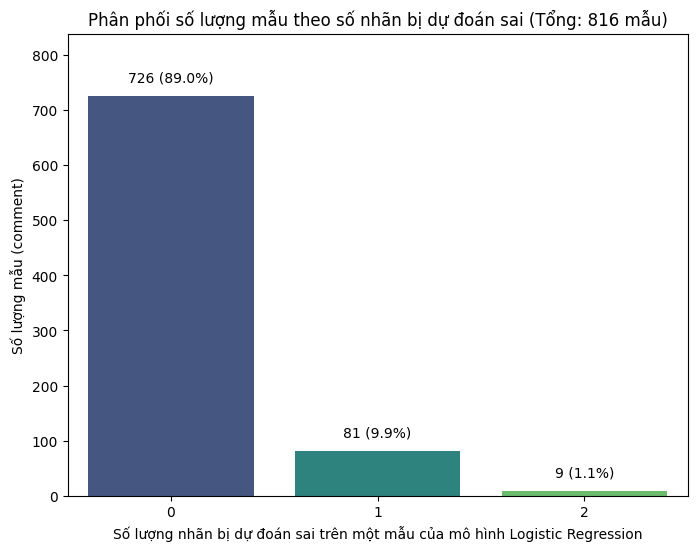

In [43]:
analyze_multilabel_prediction_errors(pipeline_logistic, X_test, y_test, ['positive', 'negative'], 'Logistic Regression')

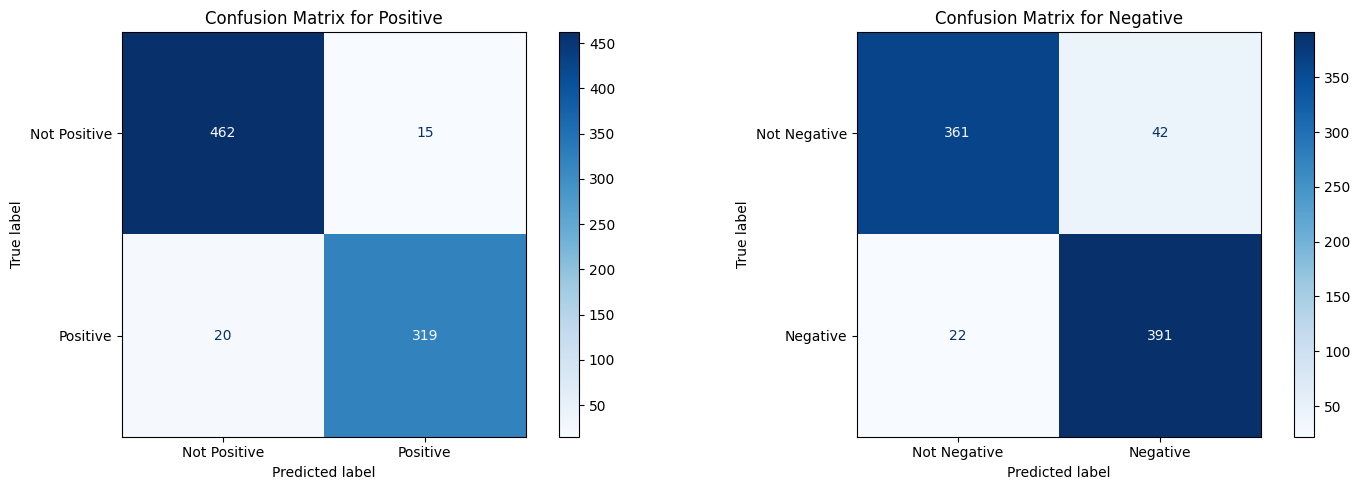

In [26]:
draw_confusion_matrix(pipeline_logistic, X_test, y_test)

In [24]:
predict_new_comment(pipeline_logistic, ["mua được tuần trả lại mất bao_nhiêu phần_trăm"])

Comment: 'mua được tuần trả lại mất bao_nhiêu phần_trăm'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.0864
  P(negative=1): 0.2127


In [25]:
predict_new_comment(pipeline_logistic, ["pin không dùng mà vẫn tụt"])

Comment: 'pin không dùng mà vẫn tụt'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.2453
  P(negative=1): 0.8373


In [26]:
predict_new_comment(pipeline_logistic, ["thế_giới di_động cường_lực honor tám không"])

Comment: 'thế_giới di_động cường_lực honor tám không'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.2996
  P(negative=1): 0.1847


In [27]:
joblib.dump(pipeline_logistic, './models/logistic.pkl')

['./models/logistic.pkl']

### Thử nghiệm với mô hình SVC

In [27]:
from sklearn.svm import SVC

In [28]:
svc_classifier = MultiOutputClassifier(SVC(kernel='linear', C=1, probability=True))

In [29]:
pipeline_svc = Pipeline([
    ('tfidf', tfidf),
    ('svc_classifier', svc_classifier)
])

In [30]:
pipeline_svc.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('svc_classifier',
                 MultiOutputClassifier(estimator=SVC(C=1, kernel='linear',
                                                     probability=True)))])

In [31]:
y_pred = pipeline_svc.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       339
           1       0.91      0.95      0.93       413

   micro avg       0.94      0.94      0.94       752
   macro avg       0.94      0.94      0.94       752
weighted avg       0.94      0.94      0.94       752
 samples avg       0.71      0.71      0.71       752

Accuracy: 0.9019607843137255


d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control thi

Phân tích lỗi dự đoán cho 2 nhãn: positive, negative

--- Thống kê số mẫu theo số lượng nhãn bị dự đoán sai ---
Tổng số mẫu trong tập test: 816
Số mẫu dự đoán đúng TẤT CẢ các nhãn: 736 (90.20%)
Số mẫu dự đoán sai ĐÚNG 1 nhãn: 72 (8.82%)
Số mẫu dự đoán sai TẤT CẢ 2 nhãn: 8 (0.98%)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5568\4109397824.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=error_counts.index, y=error_counts.values, palette="viridis")


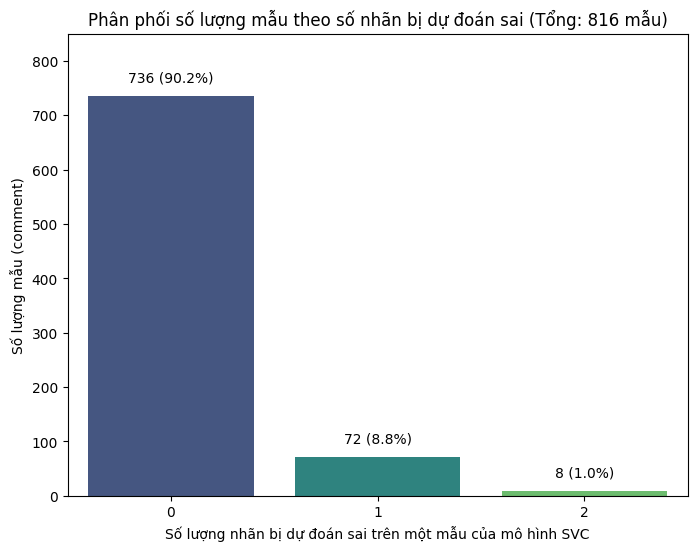

In [44]:
analyze_multilabel_prediction_errors(pipeline_svc, X_test, y_test, ['positive', 'negative'], 'SVC')

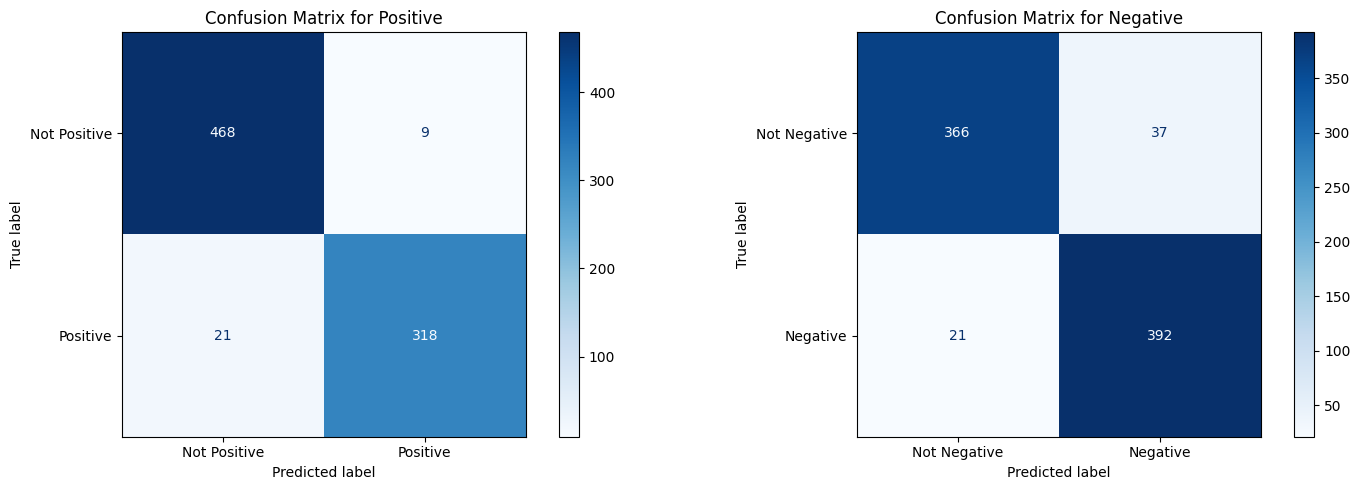

In [34]:
draw_confusion_matrix(pipeline_svc, X_test, y_test)

In [35]:
joblib.dump(pipeline_svc, './models/SVC.pkl')

['./models/SVC.pkl']

#### Testing với một số ví dụ

In [36]:
predict_new_comment(pipeline_svc, ["giá cao"])

Comment: 'giá cao'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.1240
  P(negative=1): 1.0000


In [37]:
predict_new_comment(pipeline_svc, ["giá cao quá"])

Comment: 'giá cao quá'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.0618
  P(negative=1): 1.0000


In [33]:
predict_new_comment(pipeline_svc, ["giá cao quá sao mà mua nổi"])

Comment: 'giá cao quá sao mà mua nổi'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.0438
  P(negative=1): 1.0000


In [36]:
predict_new_comment(pipeline_svc, ["giá đắt"])

Comment: 'giá đắt'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.1906
  P(negative=1): 0.7981


In [37]:
predict_new_comment(pipeline_svc, ["nhân_viên khó chịu khi tư vấn cho khách"])

Comment: 'nhân_viên khó chịu khi tư vấn cho khách'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.0573
  P(negative=1): 0.9829


In [38]:
predict_new_comment(pipeline_svc, ["đẹp lắm máy đẹp thank shop"])

Comment: 'đẹp lắm máy đẹp thank shop'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 1.0000
  P(negative=1): 0.0137


In [39]:
predict_new_comment(pipeline_svc, ["pin không dùng mà vẫn tụt"])

Comment: 'pin không dùng mà vẫn tụt'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.0298
  P(negative=1): 0.9719


In [40]:
predict_new_comment(pipeline_svc, ["tại_sao iphone mới mua dùng lại bị nóng máy"])

Comment: 'tại_sao iphone mới mua dùng lại bị nóng máy'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.0299
  P(negative=1): 0.9884


In [41]:
predict_new_comment(pipeline_svc, ["thế_giới di_động cường_lực honor tám không"])

Comment: 'thế_giới di_động cường_lực honor tám không'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.0469
  P(negative=1): 0.0116


In [44]:
predict_new_comment(pipeline_svc, ["mua được tuần trả lại mất bao_nhiêu phần_trăm"])

Comment: 'mua được tuần trả lại mất bao_nhiêu phần_trăm'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.0057
  P(negative=1): 0.0054


In [45]:
predict_new_comment(pipeline_svc, ["tốt nhưng_mà đêm tuột"])

Comment: 'tốt nhưng_mà đêm tuột'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 0.9003
  P(negative=1): 0.3755


In [46]:
predict_new_comment(pipeline_svc, ["hỏi cài vấn_đề máy được không"])

Comment: 'hỏi cài vấn_đề máy được không'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.0298
  P(negative=1): 0.0088


In [47]:
predict_new_comment(pipeline_svc, ["điện_thoại xài siêu tốt"])

Comment: 'điện_thoại xài siêu tốt'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 0.9912
  P(negative=1): 0.0309


In [48]:
predict_new_comment(pipeline_svc, ["máy dùng rất ngon mượt rất đẹp không hài_lòng lắm nhân_viên bóc siu mà chưa đồng_ý cửa khách làm nghi_ngờ máy dùng máy thấy lớp bọc mới bóc không không nhận máy"])

Comment: 'máy dùng rất ngon mượt rất đẹp không hài_lòng lắm nhân_viên bóc siu mà chưa đồng_ý cửa khách làm nghi_ngờ máy dùng máy thấy lớp bọc mới bóc không không nhận máy'
Predicted labels (positive, negative): [1 1]
Probabilities:
  P(positive=1): 0.9842
  P(negative=1): 0.7426


In [49]:
predict_new_comment(pipeline_svc, ["tạm ổn nhưng pin hôm mua xài hai hôm tụt xuống còn lại tất_cả ổn"])

Comment: 'tạm ổn nhưng pin hôm mua xài hai hôm tụt xuống còn lại tất_cả ổn'
Predicted labels (positive, negative): [1 1]
Probabilities:
  P(positive=1): 0.9842
  P(negative=1): 0.9773


In [50]:
predict_new_comment(pipeline_svc, ["hỏi dán màn_hình chưa"])

Comment: 'hỏi dán màn_hình chưa'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.0266
  P(negative=1): 0.0868


In [51]:
predict_new_comment(pipeline_logistic, ["mới dùng tháng mong thế_giới di_động hướng_dẫn cách dùng hai sim iphone 12 dùng sim vật_lý muốn dùng thẻ sim tiện công_việc"])

Comment: 'mới dùng tháng mong thế_giới di_động hướng_dẫn cách dùng hai sim iphone 12 dùng sim vật_lý muốn dùng thẻ sim tiện công_việc'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.3079
  P(negative=1): 0.2793


In [52]:
predict_new_comment(pipeline_logistic, ["góp dòng hỏi thanh_toán khoản góp tháng bằng thẻ visa cửa_hàng được không"])

Comment: 'góp dòng hỏi thanh_toán khoản góp tháng bằng thẻ visa cửa_hàng được không'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.0975
  P(negative=1): 0.2807


In [53]:
predict_new_comment(pipeline_logistic, ["phát_hiện trong camera bụi được hỗ_trợ gì không"])

Comment: 'phát_hiện trong camera bụi được hỗ_trợ gì không'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.1254
  P(negative=1): 0.3531


In [54]:
predict_new_comment(pipeline_logistic, ["sao pin tối sáng bị tụt tầm"])

Comment: 'sao pin tối sáng bị tụt tầm'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.2231
  P(negative=1): 0.7357


In [55]:
predict_new_comment(pipeline_logistic, ["giao hàng đúng hạn đóng_gói cẩn_thận"])

Comment: 'giao hàng đúng hạn đóng_gói cẩn_thận'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.4093
  P(negative=1): 0.3374


In [56]:
predict_new_comment(pipeline_logistic, ["camera chụp hình đẹp"])

Comment: 'camera chụp hình đẹp'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 0.7799
  P(negative=1): 0.4183


In [57]:
predict_new_comment(pipeline_logistic, ["camera chụp hình đẹp, dùng lâu sẽ nóng máy"])

Comment: 'camera chụp hình đẹp, dùng lâu sẽ nóng máy'
Predicted labels (positive, negative): [1 1]
Probabilities:
  P(positive=1): 0.8720
  P(negative=1): 0.5764


### Demo

In [45]:
# Load best model
best_pipeline = joblib.load('./models/SVC.pkl')

In [46]:
import sys
sys.path.insert(0, "../../")

In [47]:
from src.shared.text_preprocessing import VietnamesePreprocessingWithoutSpellCheck

Current file path: D:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis
Thu mục gốc: D:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis
Using model path: D:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\attribute_extractor\vncorenlp


In [48]:
without_spellcheck_preprocessor = VietnamesePreprocessingWithoutSpellCheck()

In [49]:
# Nhập input liên tục từ người dùng cho đến khi người dùng nhập "exit"
while True:
    user_input = input("Nhập một comment hoặc 'exit' để thoát: ")
    
    if user_input.lower() == 'exit':
        print("Thoát chương trình.")
        break
    
    print("==================================")
    print("Comment gốc:", user_input)
    proceeded_input = without_spellcheck_preprocessor(user_input)
    predict_new_comment(best_pipeline, proceeded_input)

Comment gốc: nhân viên nhiệt tình
Comment: 'nhân_viên nhiệt_tình'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 0.9940
  P(negative=1): 0.0248
Comment gốc: tháng này có khuyến mãi không
Comment: 'tháng khuyến_mãi không'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.0071
  P(negative=1): 0.0553
Comment gốc: màn hình đẹp nhưng dùng nhanh nóng máy
Comment: 'màn_hình đẹp nhưng dùng nhanh nóng máy'
Predicted labels (positive, negative): [1 1]
Probabilities:
  P(positive=1): 0.9958
  P(negative=1): 0.9971
Comment gốc: lừa đảo
Comment: 'lừa_đảo'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.1122
  P(negative=1): 0.8002
Thoát chương trình.
